In [1]:
from common_imports import *
from helper import *

# To plot pretty figures
# %matplotlib widget

Using TensorFlow backend.
/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


1.13.1


In [2]:
import hdbscan
import seaborn as sns
from sklearn import metrics
from s_dbw import S_Dbw

# %matplotlib inline
# sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Generating Gaussian Blobs

Creating data...


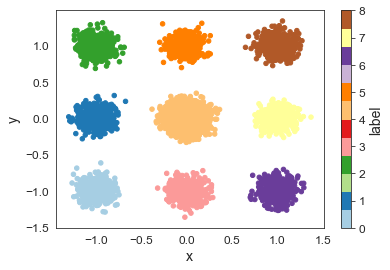

Train Size: (4000, 2)
Test Size: (4000,)
Categories: [array([0, 1])]


In [3]:
# Get split returns a generator
# List comprehension is one way to evaluate a generator

_ , data_samples, training_labels, original_labels = simulate_blobs(class_size=4000)

# Separating a hold out set that will be used for validation later
X_train, y_train, y_original, X_valid, y_valid, y_valid_original = split_valid(data_samples, original_labels, training_labels)


print("Train Size:", X_train.shape)
print("Test Size:", y_train.shape)


hot_encoder = dfHotEncoder()
hot_encoder.fit(training_labels)
print("Categories:", hot_encoder.categories_)

In [4]:
MODEL_ZOO = []
ZSCALERS = []
MODELDIR = "models/"
INITFILE = MODELDIR+"init.h5"
BASENAME = MODELDIR+"dnn"

def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
#     keras.backend.clear_session()
    
    nn = keras.models.Sequential()
    Dense = keras.layers.Dense
    
    # Using He initialization
    he_init = tf.keras.initializers.he_uniform()
    
    nn.add(Dense(units = num_nodes, activation=activation, input_dim=num_features,
                kernel_initializer=he_init))
    
    for i in range(1,depth):
        nn.add(Dense(units = num_nodes, activation=activation,
                    kernel_initializer=he_init))

    nn.add(Dense(units=num_labels, activation= "softmax",
                kernel_initializer=he_init))
    
    nn.compile(loss="categorical_crossentropy",
                  optimizer='sgd',
                  metrics=['accuracy'])
    
    return nn

def train_model(model, X, y, epochs=30, batch_size=20, verbose=0):
    from sklearn.preprocessing import StandardScaler
    from imblearn.over_sampling import SMOTE
    
    model.load_weights(INITFILE)
    
    ZScaler = StandardScaler().fit(X)
    
    X_train = ZScaler.transform(X)
    y_train = hot_encoder.transform(y)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size = batch_size, verbose=verbose)
    

    return history, ZScaler

'''
Assumes categorical output from DNN
'''
def getCorrectPredictions(model, samples, labels, enc):
    import numpy as np
    
    predictions = model.predict(samples)
    preds = np.array([np.argmax(x) for x in predictions])
    true_labels = np.array([x for x in labels])

    correct = preds == true_labels
    
    return samples[correct], labels[correct], correct


In [5]:
def runDNN(depth, epochs, train_data, test_data,foldnum):
    import innvestigate
    import innvestigate.utils as iutils
    
    X_train, y_train = train_data
    X_test, y_test = test_data
    num_features = X_train.shape[1]
    
    nn = build_dnn(num_features)


    history, ZScaler = train_model(nn, X_train, y_train,
                                   epochs=epochs, batch_size=20)

    scaled_samples = ZScaler.transform(X_test)
    final_acc = nn.evaluate(scaled_samples, hot_encoder.transform(y_test), verbose=0)

    # Getting all the samples that can be correctly predicted
    all_samples, _labels, correct_idxs = getCorrectPredictions(nn, scaled_samples, y_test, enc = hot_encoder)

    # Stripping the softmax activation from the model
    model_w_softmax = nn
    model = iutils.keras.graph.model_wo_softmax(model_w_softmax)

    # Creating an analyzer
    lrp_E = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPEpsilon(model=model, epsilon=1e-3)
    lrp_results = lrp_E.analyze(all_samples)
    
    model.save_weights(
        "{basename}_{id}.h5".format(basename=BASENAME, id=foldnum)
    )
    
    ZSCALERS.append(ZScaler)
    
    
    return (final_acc, lrp_results, correct_idxs)

def runCV(depth,epochs, X, y, y_original):
    
#     start_time = time()
    cv_original_labels = []
    cv_lrp_results = []
    cv_testing_indxs = []
    
    for i, (train_index, test_index) in enumerate(getKF(X, y_original)):

        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test  = X.iloc[test_index]
        y_test = y.iloc[test_index]
        y_test_original = y_original.iloc[test_index]

        final_acc, lrp_results, correct_predictions = runDNN(depth, epochs, train_data = [X_train,y_train], test_data = [X_test, y_test], foldnum=i)

        cv_original_labels.extend(y_test_original[correct_predictions])
        cv_lrp_results.extend(lrp_results)
        cv_testing_indxs.extend(test_index[correct_predictions])

        print("{}/{}, Fold {} scores: loss={:0.3f} accuracy={:.4f}".format(
            depth, epochs, i, final_acc[0], final_acc[1]))

#     print("{}/{} Runtime: {:.3f}s".format(depth, epoch, time()-start_time))

    return (cv_lrp_results, cv_original_labels, cv_testing_indxs)

In [6]:
MODEL_ZOO = []
ZSCALERS = []
NUMCV = 10
%time cv_lrp_results, cv_original_labels, cv_testing_indxs = runCV(depth=5,epochs=100, X=X_train, y=y_train, y_original=y_original)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
5/100, Fold 0 scores: loss=0.001 accuracy=1.0000
5/100, Fold 1 scores: loss=0.001 accuracy=1.0000
5/100, Fold 2 scores: loss=0.000 accuracy=1.0000
5/100, Fold 3 scores: loss=0.001 accuracy=1.0000
5/100, Fold 4 scores: loss=0.001 accuracy=1.0000
5/100, Fold 5 scores: loss=0.000 accuracy=1.0000
5/100, Fold 6 scores: loss=0.001 accuracy=1.0000
5/100, Fold 7 scores: loss=0.001 accuracy=1.0000
5/100, Fold 8 scores: loss=0.000 accuracy=1.0000
5/100, Fold 9 scores: loss=0.000 accuracy=1.0000
CPU times: user 3min 11s, sys: 52.7 s, total: 4min 4s
Wall time: 1min 57s


## Plotting LRP

In [7]:
from scipy.stats import entropy
'''
Expects data to be 2D numpy array
'''
def calculateEntropy(data, plot=False):
    from scipy.stats import entropy
    
    nsamples = len(data)
    nbins = 30

    xedges = np.linspace(0,15,nbins+1)
    yedges = np.linspace(0,15,nbins+1)
    
    x = np.clip(data[:,0], xedges[0], xedges[-1])
    y = np.clip(data[:,1], yedges[0], yedges[-1])
    
    grid, xedges, yedges = np.histogram2d(x, y, bins=[xedges,yedges])
    densities = (grid/nsamples).flatten()
    
    if plot:
        fig, ax = plt.subplots(1, figsize=(8, 8))

        ax.imshow(grid, interpolation='nearest', origin='low',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="jet")
#         plt.colorbar()
        plt.show()
    
    return entropy(densities)

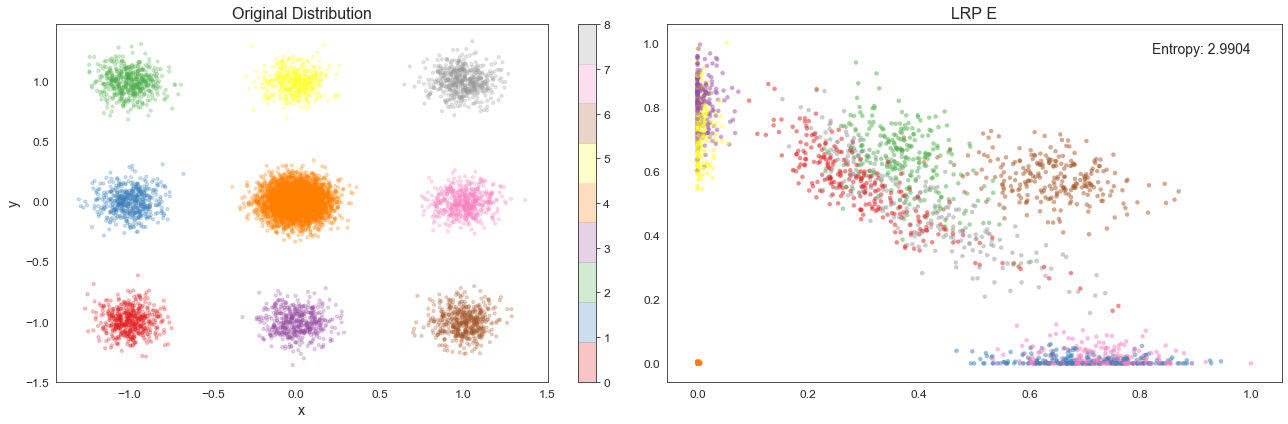

In [46]:
from sklearn.preprocessing import MinMaxScaler

plt.close("Positive Only LRP")
fig, axs = plt.subplots(1,2, figsize=(18,6), num="Positive Only LRP")

cmap = "Set1" #"Paired"
plot_args = {"kind":"scatter", "x":0,  "y":1, "c":"label", "cmap": cmap, "s":10, "alpha":0.25}
plot_args["c"] = original_labels

data_samples.plot(ax=axs[0],title="Original Distribution", **plot_args)

data = np.clip(cv_lrp_results, 0,None)
lrp_entropy = calculateEntropy(data)

sdata = MinMaxScaler().fit_transform(data)

axs[1].scatter(*sdata.T, s=20, linewidth=0, c=cv_original_labels, alpha=0.5, cmap=plot_args["cmap"])
axs[1].set_title("LRP E")
axs[1].text(0.95,0.95,"Entropy: {:.4f}".format(lrp_entropy),
            horizontalalignment='right', verticalalignment='top',
            fontsize=14, transform=axs[1].transAxes)

plt.tight_layout()
plt.show()

# Beginning Clustering using accelerated HDBSCAN*

In [9]:
# Score for original dataset
score_orig = S_Dbw(data_samples.values, original_labels, centers_id=None, method='Halkidi',
centr='mean', nearest_centr=True, metric='euclidean')
score_orig

0.1599028414948201

# Plotting Clustering Performance

## Defining Function for Scoring Clusters

In [10]:
def clusterPerf(data, labels, cluster_sizes):

    plt.close("Cluster Comparison")
    fig, axs = plt.subplots(1+len(cluster_sizes), 1, figsize=(16,8*(1+len(cluster_sizes))), num="Cluster Comparison")
    plt.title("Cluster Comparison")


    axs[0].scatter(*data.T, s=50, linewidth=0, c=labels, alpha=0.5, cmap="Set1")
    axs[0].set_title("Original Distribution")

    _metrics = []

    for i,size in enumerate(cluster_sizes):
        clusterer = hdbscan.HDBSCAN(min_cluster_size=size)
        clusterer.fit(data)
        cluster_labels = clusterer.labels_

         ## Number of clusters in labels, ignoring noise if present.
        num_clusters = cluster_labels.max() + 1

        color_palette = sns.color_palette("bright", num_clusters)
        cluster_colors = [color_palette[x] if x >= 0
                          else (0, 0, 0)
                          for x in clusterer.labels_]
        cluster_member_colors = [sns.desaturate(x, p) for x, p in
                                 zip(cluster_colors, clusterer.probabilities_)]

        print(cluster_labels)
        
        noise = list(cluster_labels).count(-1)/len(cluster_labels)

        halkidi_s_Dbw = S_Dbw(data, cluster_labels, alg_noise="comb", method='Halkidi',
                    centr='mean', nearest_centr=True, metric='euclidean')
        
        halkidi_ignore_noise = S_Dbw(data, cluster_labels, alg_noise="filter", method='Halkidi',
                    centr='mean', nearest_centr=True, metric='euclidean')
        
        halkidi_bind = S_Dbw(data, cluster_labels, alg_noise="bind", method='Halkidi',
                    centr='mean', nearest_centr=True, metric='euclidean')
        
        sil_score = metrics.silhouette_score(data, cluster_labels, metric="euclidean")
        
        _metrics.append([num_clusters,noise,sil_score, halkidi_s_Dbw, halkidi_ignore_noise, halkidi_bind])


        axs[i+1].scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.6)
        axs[i+1].set_title("Minimum Cluster Size: {}".format(size))
        axs[i+1].text(0.95,0.95,"Clusters Found: {}".format(num_clusters),
                    horizontalalignment='right', verticalalignment='top',
                    fontsize=14, transform=axs[i+1].transAxes)

    # plt.tight_layout()
    plt.show()
    scores = pd.DataFrame(_metrics, columns=["Clusters", "Noise", "Silhouette","Halkidi", "Halkidi-Filtered Noise", "Halkidi-Bounded Noise"], index=cluster_sizes)
    
    return scores

[6 1 0 ... 4 6 5]
[4 1 0 ... 3 4 2]
[0 2 1 ... 3 0 4]
[0 2 1 ... 4 0 3]
[0 2 1 ... 4 0 3]
[ 0  2  1 ...  3  0 -1]
[ 0  3  1 ...  2  0 -1]
[ 0  2  1 ...  3  0 -1]
[0 2 1 ... 2 0 2]
[0 2 1 ... 2 0 2]
[0 2 1 ... 2 0 2]
[0 1 2 ... 1 0 1]
[ 0  2  1 ...  2  0 -1]
[ 0  2  1 ...  2  0 -1]
[ 0  2  1 ...  2  0 -1]


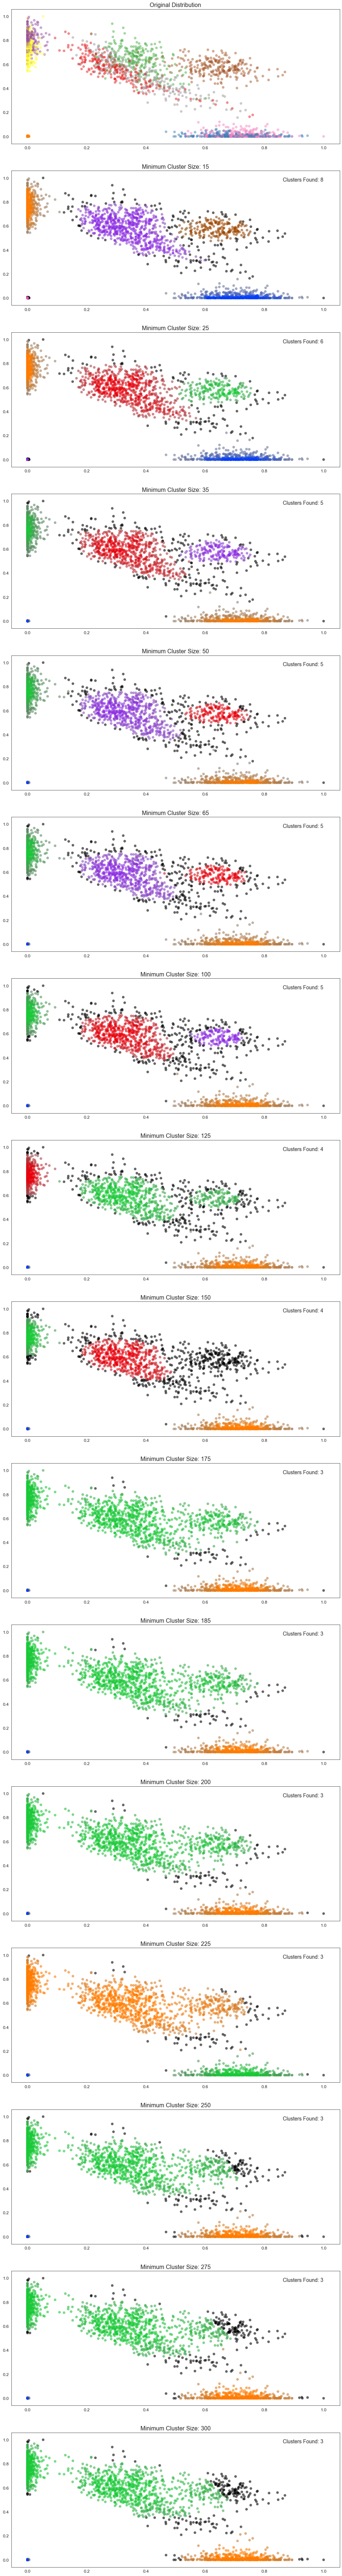

,Clusters,Noise,Silhouette,Halkidi,Halkidi-Filtered Noise,Halkidi-Bounded Noise
15,8,0.08750,0.647987,0.450802,0.394464,0.439335
25,6,0.06575,0.674948,0.408433,0.270311,0.306107
35,5,0.05050,0.771309,0.450150,0.258013,0.323409
50,5,0.05825,0.767902,0.439107,0.245591,0.327024
65,5,0.06500,0.764252,0.436385,0.237778,0.331201
100,5,0.08025,0.750372,0.443457,0.220639,0.331356
125,4,0.07750,0.739309,0.466808,0.282887,0.389348
150,4,0.12925,0.750388,0.411668,0.216371,0.383287
175,3,0.01325,0.705340,0.690526,0.391197,0.416215
185,3,0.01375,0.704984,0.687651,0.393781,0.421463


In [48]:
data = np.clip(cv_lrp_results, 0,None)
sdata = MinMaxScaler().fit_transform(data)
labels = cv_original_labels
cluster_sizes = [15,25,35,50,65,100,125,150,175,185,200,225,250,275,300]

scores = clusterPerf(sdata, labels, cluster_sizes)
scores

In [49]:
# plt.savefig(figures_dir+"cluster_perf_comp.png")

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/pandas/plotting/_core.py:1801: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a401842b0>,
      dtype=object)

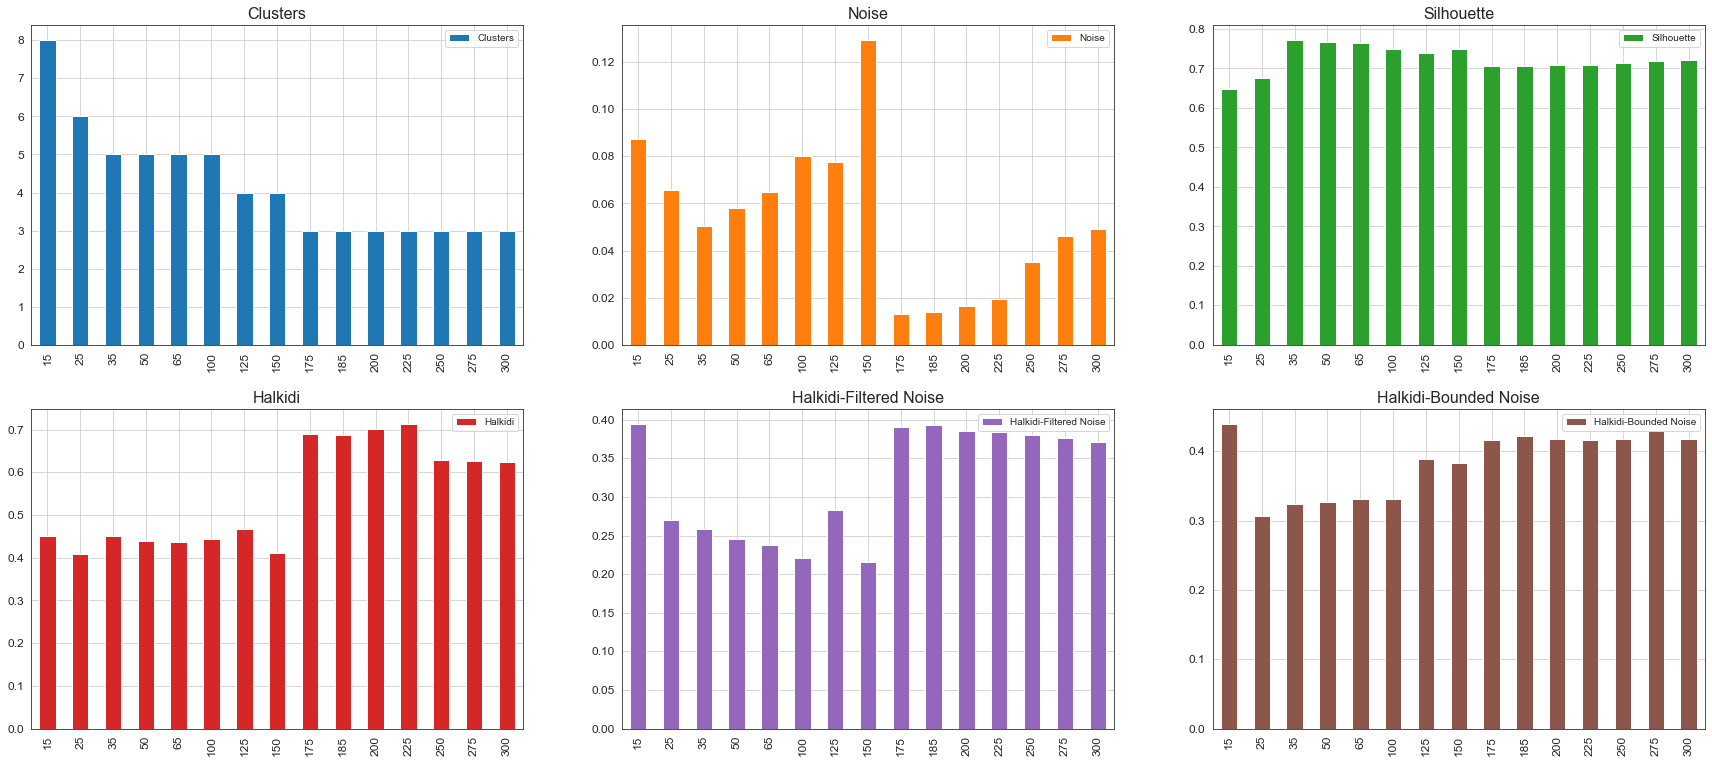

In [50]:
plt.close("Cluster Scores")
fig, axs = plt.subplots(figsize=(30,20), num="Cluster Scores")
plt.title("Cluster Scores")

scores.plot(kind="bar", ax=axs, subplots=True, layout=(3,3), grid=True)

In [51]:
# plt.savefig(figures_dir+"cluster_perf_score.png")

In [52]:
scores.idxmin()

Clusters                  175
Noise                     175
Silhouette                 15
Halkidi                    25
Halkidi-Filtered Noise    150
Halkidi-Bounded Noise      25
dtype: int64

# Applying Linear Classifier on Clusters

In [53]:
minsize = int(scores["Halkidi-Filtered Noise"].idxmin())
# minsize = 65

In [63]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=minsize, prediction_data=True)
clusterer.fit(sdata)
clusterer

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_method='eom',
        core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=150, min_samples=None, p=None,
        prediction_data=True)

### Generate outputs form DNN

### Prediction array is num_samples x num_models x [prediction, softmax_probability]
> Pick the highest "confidence" and its corresponding prediction

In [64]:
# Get the model architecture
num_features = X_train.shape[1]
model = build_dnn(num_features)

In [65]:
predictions = []
for i,zscaler in enumerate(ZSCALERS):
    model.load_weights(
    "{basename}_{id}.h5".format(basename=BASENAME, id=i))
    _samples = zscaler.transform(X_valid)
    model_preds = np.array([(np.argmax(x), np.max(x)) for x in model.predict(_samples)])
    predictions.append(model_preds)

# Combine all DNN predictions into a matrix
predictions = np.stack(predictions, axis=1)
predictions

array([[[1.        , 0.9998275 ],
        [1.        , 0.99983084],
        [1.        , 0.99983275],
        ...,
        [1.        , 0.99982774],
        [1.        , 0.99983096],
        [1.        , 0.99983191]],

       [[0.        , 0.99999857],
        [0.        , 0.99999821],
        [0.        , 0.99999809],
        ...,
        [0.        , 0.99999857],
        [0.        , 0.99999833],
        [0.        , 0.99999833]],

       [[1.        , 0.99873334],
        [1.        , 0.99879068],
        [1.        , 0.9988004 ],
        ...,
        [1.        , 0.99874038],
        [1.        , 0.99880886],
        [1.        , 0.99880219]],

       ...,

       [[0.        , 1.        ],
        [0.        , 1.        ],
        [0.        , 1.        ],
        ...,
        [0.        , 1.        ],
        [0.        , 1.        ],
        [0.        , 1.        ]],

       [[0.        , 0.99999976],
        [0.        , 0.99999976],
        [0.        , 0.99999976],
        .

# TODO: Drop values which were predicted incorrectly
> just set them to [-1,-1]

In [66]:
best_DNN = np.argmax(predictions[:,:,1], axis=1)
best_predictions = predictions[range(len(X_valid)), best_DNN,0].astype(int)

### Run LRP using best DNN for each sample 

In [67]:
best_DNN

array([2, 0, 8, ..., 0, 0, 2])

In [24]:
# def runAnalysis(nn, sample):
#     model_w_softmax = nn
#     model = iutils.keras.graph.model_wo_softmax(model_w_softmax)

#     # Creating an analyzer
#     lrp_E = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPEpsilon(model=model, epsilon=1e-3)

#     return lrp_E.analyze(sample)

NUMCV = 10
lrp_zoo = []
for dnn_idx in range(NUMCV):
    model.load_weights(
    "{basename}_{id}.h5".format(basename=BASENAME, id=dnn_idx))
    model_w_softmax = model
    model_wo_softmax = iutils.keras.graph.model_wo_softmax(model_w_softmax)

    # Creating an analyzer
    lrp_zoo.append(
        innvestigate.analyzer.relevance_based.relevance_analyzer.LRPEpsilon(
        model=model_wo_softmax, epsilon=1e-3))

print("Loaded LRP models...")

analyze = lambda idx,x: lrp_zoo[idx].analyze(x.reshape(1,-1))

Loaded LRP models...


In [68]:
val_set_lrp = []

for dnn_idx, sample in zip(best_DNN, X_valid.values):
    val_set_lrp.extend(analyze(dnn_idx,sample))

### Assign a cluster to all the points in the validation set when possible

In [69]:
data = np.clip(val_set_lrp, 0,None)
sdata = MinMaxScaler().fit_transform(data)
cluster_labels, strengths = hdbscan.approximate_predict(clusterer, sdata)

In [70]:
cluster_labels

array([0, 2, 0, ..., 2, 2, 0])

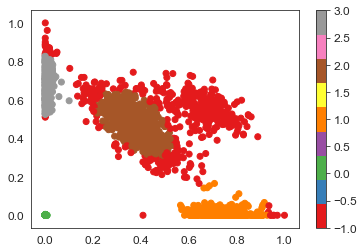

In [71]:
# xvals = [x[0] for x in val_set_lrp]
# yvals = [x[1] for x in val_set_lrp]
plt.scatter(*sdata.T, c=cluster_labels, cmap="Set1")
plt.colorbar()

## ~~TODO: USE MINMAX SCALER ON AGGREGATED CV LRP DATA BEOFRE CLUSTERING~~

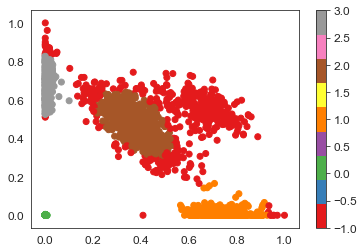

In [72]:
from sklearn.preprocessing import MinMaxScaler
sdata = MinMaxScaler().fit_transform(data)
plt.scatter(*sdata.T, c=cluster_labels, cmap="Set1")
plt.colorbar()

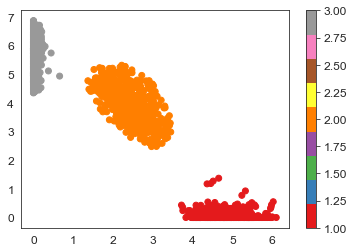

In [75]:
clustered_points = cluster_labels > 0
plt.scatter(*data[clustered_points].T, c=cluster_labels[clustered_points], cmap="Set1")
plt.colorbar()

In [76]:
len(X_valid[clustered_points])

1390

## ~~FIX: Get class A from np.logical_and(y_valid == 1, cluster_labels > -1)~~

In [77]:
class_A = X_valid[np.logical_and(y_valid == 1, cluster_labels > -1) ] # turn into np.logical_and(y_valid == 1, cluster_labels > -1) 
class_B = X_valid[np.logical_and(y_valid == 0, cluster_labels > -1) ]
class_A_cluster_labels = cluster_labels[np.logical_and(y_valid == 1, cluster_labels > -1) ]
class_B_cluster_labels = cluster_labels[np.logical_and(y_valid == 0, cluster_labels > -1) ]

In [78]:
csize = min(len(class_A_cluster_labels), len(class_B_cluster_labels))

class_A, class_A_labels = class_A[:csize], class_A_cluster_labels[:csize]
class_B, class_B_labels = class_B[:csize], class_B_cluster_labels[:csize]

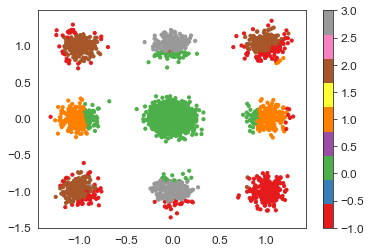

In [127]:
plt.scatter(X_valid["x"], X_valid["y"], c=cluster_labels, s=plot_args["s"], cmap=plot_args["cmap"])
plt.colorbar()

In [115]:
plot_args

{'kind': 'scatter',
 'x': 0,
 'y': 1,
 'c': array([2, 0, 3, ..., 2, 2, 2]),
 'cmap': 'Set1',
 's': 10,
 'alpha': 0.25}

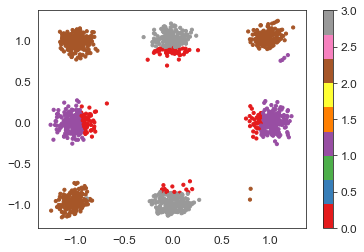

In [124]:
plt.scatter(class_B["x"], class_B["y"], c=class_B_labels, s=plot_args["s"], cmap=plot_args["cmap"])
plt.colorbar()

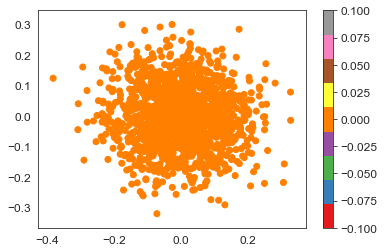

In [81]:
plt.scatter(class_A["x"], class_A["y"], c=class_A_labels, cmap="Set1")
plt.colorbar()

## Performing a one-vs-rest type analysis
### Center Blob vs Surrounding Subclasses

In [92]:
center_class = X_valid[cluster_labels == 0]
center_labels = cluster_labels[ cluster_labels == 0]

xtrain = {}

for i in range(1, cluster_labels.max()+1):
    
    _subclass = X_valid[cluster_labels == i]
    _labels = cluster_labels[ cluster_labels == i]
    
    _xtrain = np.concatenate((center_class[:len(_subclass)], _subclass))
    _ytrain = np.concatenate((center_labels[:len(_subclass)], _labels))
    
    xtrain[i] = (_xtrain, _ytrain)

In [146]:
xtrain[1][1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Establishing Baseline

In [151]:
def split_valid(features, training_labels, original_labels=None, valid_size=0.5):
    train_index, validation_index = get_split_index(features, training_labels, test_size=valid_size)[0]
    
    X_valid, y_valid = features[validation_index], training_labels[validation_index], 
    X_train, y_train = features[train_index], training_labels[train_index]
    
    y_original = None
    y_valid_original = None
    
    if original_labels:
        y_original = original_labels[train_index]
        y_valid_original = original_labels[validation_index]
        
    return X_train, y_train, y_original, X_valid, y_valid, y_valid_original

In [203]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM", LinearSVC(**{'C': 100, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}))
])

%time svm_clf.fit(X_train, y_train)
print("Linear SVM Test Accuracy: {:0.3f}".format(svm_clf.score(X_valid, y_valid)))

CPU times: user 113 ms, sys: 1.99 ms, total: 115 ms
Wall time: 115 ms
Linear SVM Test Accuracy: 0.688


In [204]:
from sklearn.model_selection import cross_val_score
scores = []
for i in xtrain:
    print("\tSubcluster",i)
#     _xtrain, _ytrain, _ , _xvalid, _yvalid, _ = split_valid(xtrain[i][0], xtrain[i][1],valid_size=0.1)
#     print("Size:", _ytrain.shape, _yvalid.shape)
    
    %time _score = cross_val_score(svm_clf, X = xtrain[i][0], y=xtrain[i][1], cv=10)
    
#     %time svm_clf.fit(_xtrain, _ytrain)
    scores.append(_score)
    print("SVM Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))

	Subcluster 1
CPU times: user 1.61 s, sys: 4.07 ms, total: 1.62 s
Wall time: 1.62 s
SVM Accuracy: 0.747(+/- 0.061)
	Subcluster 2
CPU times: user 1.33 s, sys: 1.73 ms, total: 1.33 s
Wall time: 1.33 s
SVM Accuracy: 0.844(+/- 0.052)
	Subcluster 3
CPU times: user 1.02 s, sys: 1.38 ms, total: 1.02 s
Wall time: 1.02 s
SVM Accuracy: 0.632(+/- 0.155)


In [205]:
np.mean([s.mean() for s in scores])

0.7411813807015436

### Getting the best parameters for the data using a grid search

In [210]:
from sklearn.model_selection import cross_val_score


param_grid = [
    {"dual":[False],"max_iter":[10000000], "penalty":["l1","l2"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
    { "max_iter":[10000000], "loss":["squared_hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
    { "max_iter":[10000000], "loss":["hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]}
]

lsvc = LinearSVC()
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVMGrid",GridSearchCV(lsvc, param_grid, cv=10, iid=False, scoring="neg_mean_squared_error", n_jobs=4))
])

scores = []
for i in xtrain:
    print("\tSubcluster",i)

    %time clf.fit(xtrain[i][0], xtrain[i][1])
    
    grid = clf.steps[1][1]
    print(grid.best_params_)

    svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("SVM", LinearSVC(**grid.best_params_))
    ])
    
    _score = cross_val_score(svm_clf, X = xtrain[i][0], y=xtrain[i][1], cv=10)

    scores.append(_score)
    
    print("SVM Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))

	Subcluster 1
CPU times: user 150 ms, sys: 8.52 ms, total: 159 ms
Wall time: 48.4 s
{'C': 10, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}
SVM Accuracy: 0.747(+/- 0.061)
	Subcluster 2
CPU times: user 106 ms, sys: 3.34 ms, total: 109 ms
Wall time: 23.9 s
{'C': 1, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}
SVM Accuracy: 0.844(+/- 0.052)
	Subcluster 3
CPU times: user 161 ms, sys: 5.75 ms, total: 166 ms
Wall time: 1min 23s
{'C': 10, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}
SVM Accuracy: 0.632(+/- 0.155)


	Subcluster 1
CPU times: user 150 ms, sys: 8.52 ms, total: 159 ms

Wall time: 48.4 s

{'C': 10, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}

SVM Accuracy: 0.747(+/- 0.061)


	Subcluster 2
CPU times: user 106 ms, sys: 3.34 ms, total: 109 ms

Wall time: 23.9 s

{'C': 1, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}

SVM Accuracy: 0.844(+/- 0.052)

Subcluster 3

CPU times: user 161 ms, sys: 5.75 ms, total: 166 ms

Wall time: 1min 23s

{'C': 10, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}

SVM Accuracy: 0.632(+/- 0.155)

Mean: 0.7411

In [225]:
np.mean([s.mean() for s in scores])

0.47853608211023774

### For the original dataset, the defaults are best

In [107]:
# param_grid = [
#     {"dual":[False],"max_iter":[1000000], "penalty":["l1","l2"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
#     { "max_iter":[1000000], "loss":["squared_hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
#     { "max_iter":[1000000], "loss":["hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]}
# ]

# lsvc = LinearSVC()
# clf = Pipeline([
#     ("scaler", StandardScaler()),
#     ("SVMGrid",GridSearchCV(lsvc, param_grid, cv=10, scoring="neg_mean_squared_error", n_jobs=8))
# ])
# %time clf.fit(X_train,y_train)

# grid = clf.steps[1][1]
# best_params = grid.best_params_
# best_params # {'C': 1, 'loss': 'hinge', 'max_iter': 1000000, 'tol': 0.0001}

# svm_clf = Pipeline([
#     ("scaler", StandardScaler()),
#     ("SVM", LinearSVC(**best_params))
# ])

# %time svm_clf.fit(X_train, y_train)
# print("Linear SVM Test Accuracy: {:0.3f}".format(svm_clf.score(X_valid, y_valid)))

### SVM Accuracies

Original Data: 0.688

Clustered Data Avg: 0.741

## Trying SVC with different kernels

In [226]:
from sklearn.svm import SVC

nlsvm = SVC()

nlsvm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM", SVC(kernel="poly", C=1, gamma="scale", degree=3))
])

%time nlsvm_clf.fit(X_train, y_train)
print("SVM Test Accuracy: {:0.3f}".format(nlsvm_clf.score(X_valid, y_valid)))

CPU times: user 526 ms, sys: 9.52 ms, total: 536 ms
Wall time: 535 ms
SVM Test Accuracy: 0.637


In [227]:
from sklearn.model_selection import cross_val_score
scores = []
for i in xtrain:
    print("\tSubcluster",i)
    %time _score = cross_val_score(nlsvm_clf, X = xtrain[i][0], y=xtrain[i][1], cv=10)
    scores.append(_score)
    print("SVM Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))

subcluster_avg = np.mean([s.mean() for s in scores])
print("Mean Score: {:0.4f}".format(subcluster_avg))

	Subcluster 1
CPU times: user 308 ms, sys: 3.12 ms, total: 311 ms
Wall time: 310 ms
SVM Accuracy: 0.642(+/- 0.065)
	Subcluster 2
CPU times: user 51.3 ms, sys: 496 µs, total: 51.8 ms
Wall time: 51.8 ms
SVM Accuracy: 0.996(+/- 0.012)
	Subcluster 3
CPU times: user 376 ms, sys: 824 µs, total: 377 ms
Wall time: 376 ms
SVM Accuracy: 0.648(+/- 0.088)
Mean Score: 0.7620


In [131]:
param_grid = [
    {"kernel":["sigmoid,poly"],"gamma":["auto", "scale"], "shrinking":[False], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]}
#     {"kernel":["poly"], "degree":[3,4,5], "gamma":["auto", "scale"], "shrinking":[False], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
]

nlsvc = SVC()

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVMGrid",GridSearchCV(lsvc, param_grid, cv=10, iid=False, scoring="neg_mean_squared_error", n_jobs=4))
])

scores = []
for i in xtrain:
    print("\tSubcluster",i)

    %time clf.fit(xtrain[i][0], xtrain[i][1])
    
    grid = clf.steps[1][1]
    print(grid.best_params_)

    svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("SVM", LinearSVC(**grid.best_params_))
    ])
    
    _score = cross_val_score(svm_clf, X = xtrain[i][0], y=xtrain[i][1], cv=10)

    scores.append(_score)
    
    print("SVM Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))

exception calling callback for <Future at 0x133f63ac8 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py", line 309, in __call__
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py", line 731, in dispatch_next
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py", line 759, in dispatch_one_batch
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py", line 716, in _dispatch
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/sklearn/externals/joblib/_parallel_backends.py", line 510, in apply_async
  File "/Use

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {EXIT(1)}